In [1]:
from ultralytics import YOLO
import cv2

In [2]:
model = YOLO('yolov8s-seg.pt') 
image = cv2.imread('original_bus.jpg')

desired_image_size = (640, 640)

# change input size according to the resolution of the image you want to process
# e.g. desired_image_size = (640, 640)

In [3]:
model.export(format='onnx', imgsz=desired_image_size)

Ultralytics YOLOv8.1.17 🚀 Python-3.12.1 torch-2.2.0+cu121 CPU (11th Gen Intel Core(TM) i9-11950H 2.60GHz)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

PyTorch: starting from 'yolov8s-seg.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 116, 8400), (1, 32, 160, 160)) (22.8 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 0.7s, saved as 'yolov8s-seg.onnx' (45.3 MB)

Export complete (2.2s)
Results saved to /home/matteo/Documents/my_experiments/yolov8/TensorRT-YOLOv8-Instance-Segmentation
Predict:         yolo predict task=segment model=yolov8s-seg.onnx imgsz=640  
Validate:        yolo val task=segment model=yolov8s-seg.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8s-seg.onnx'

----------------------------------
## TEST INFERENCE WITH ONNX RUNTIME

In [4]:
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

# import utils file fot postprocessing and visualization
import utils

In [5]:
# Load YOLOv8s-seg model
model_path = 'yolov8s-seg.onnx'
ort_session = ort.InferenceSession(model_path)

### Preprocess the image

In [6]:
resized_image = cv2.resize(image, desired_image_size) ## <---- if you need to resize the image
input_image = resized_image.astype(np.float32) / 255.0
input_image = np.transpose(input_image, [2, 0, 1])  # Change image layout to CHW (Channels First)
input_image = np.expand_dims(input_image, axis=0) 

In [7]:
input_image.shape

(1, 3, 640, 640)

In [8]:
image.shape

(1080, 810, 3)

### Perform inference

In [9]:
outputs = ort_session.run(None, {'images': input_image})
output_0=np.squeeze(outputs[0])
prototypes=np.squeeze(outputs[1])

In [10]:
# check the output shape
print("output_0 shape: ", output_0.shape)
print("prototypes shape: ", prototypes.shape)

output_0 shape:  (116, 8400)
prototypes shape:  (32, 160, 160)


### Visualize the resulting masks according with YOLACT postprocessing
url: https://openaccess.thecvf.com/content_ICCV_2019/papers/Bolya_YOLACT_Real-Time_Instance_Segmentation_ICCV_2019_paper.pdf

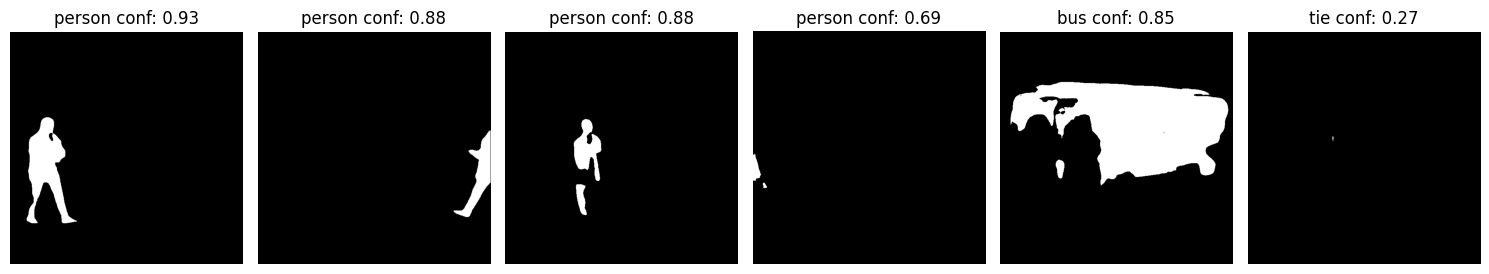

In [11]:
output_0=np.squeeze(outputs[0])
prototypes=np.squeeze(outputs[1])
l_mask,l_class,l_conf=utils.extract_masks(output_0,prototypes,desired_image_size)

# Determine the number of subplots needed
num_plots = len(l_mask)

# Calculate the number of rows and columns for the subplot grid
num_rows = 1  # Number of rows
num_cols = num_plots  # Number of columns

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Iterate over each subplot
for k, ax in enumerate(axes):
    ax.imshow(l_mask[k], cmap='gray')
    title = f"{utils.classes[l_class[k]]} conf: {l_conf[k]:.2f}"
    ax.set_title(title)
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout
plt.show()